# Clasificador de Imágenes: Piezas de ajedrez

In [53]:
import os
from pathlib import Path
import shutil

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Utilizamos optuna para encontrar los mejores hiperparámetros

In [54]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    data_path = 'data/raw/Chess'    

    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])

    test_data.dataset.transform = transform_test

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 5
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-03 11:52:56,461] A new study created in memory with name: no-name-3a3bab90-22fa-462e-a14a-28ad789bb7b1
[I 2024-12-03 11:53:25,142] Trial 0 finished with value: 17.117117117117118 and parameters: {'batch_size': 128, 'lr': 6.662859622652303e-05, 'dropout_rate': 0.36513588082620985}. Best is trial 0 with value: 17.117117117117118.
[I 2024-12-03 11:53:53,962] Trial 1 finished with value: 19.81981981981982 and parameters: {'batch_size': 64, 'lr': 0.0015769620302722388, 'dropout_rate': 0.39148567109470156}. Best is trial 1 with value: 19.81981981981982.
[I 2024-12-03 11:54:22,375] Trial 2 finished with value: 16.216216216216218 and parameters: {'batch_size': 32, 'lr': 0.006699145419393379, 'dropout_rate': 0.4801019420961482}. Best is trial 1 with value: 19.81981981981982.
[I 2024-12-03 11:54:52,893] Trial 3 finished with value: 20.72072072072072 and parameters: {'batch_size': 16, 'lr': 1.0735874757297213e-05, 'dropout_rate': 0.4816420848962134}. Best is trial 3 with value: 20.7207

Best hyperparameters: {'batch_size': 16, 'lr': 0.00036729071990711357, 'dropout_rate': 0.10411715065180918}


Creamos un clasificador básico usando los datos originales.

In [55]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/raw/Chess'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [56]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        """
        Inicializa el criterio para la parada temprana.
        
        Args:
            tolerance (int): Número de épocas sin mejora para detener el entrenamiento.
            min_delta (float): La mínima mejora que se necesita en la pérdida de validación.
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        """
        Llama a la función con la pérdida de entrenamiento y de validación.
        
        Args:
            train_loss (float): La pérdida en el conjunto de entrenamiento.
            validation_loss (float): La pérdida en el conjunto de validación.
        """
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

In [30]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
    """
    Genera gráficas de las métricas: pérdida y precisión, además de la matriz de confusión.
    """
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Crear y graficar la matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

Clasificador básico:

(Sin parada temprana)

Epoch 1, Training Loss: 1.8081024416855402, Training Accuracy: 17.687074829931973%
Epoch 1, Test Loss: 1.7782461302621024, Test Accuracy: 21.62162162162162%
Epoch 2, Training Loss: 1.7597185671329498, Training Accuracy: 24.94331065759637%
Epoch 2, Test Loss: 1.7823364394051688, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7182787954807281, Training Accuracy: 24.263038548752835%
Epoch 3, Test Loss: 1.7563927514212472, Test Accuracy: 21.62162162162162%
Epoch 4, Training Loss: 1.6392157886709486, Training Accuracy: 31.972789115646258%
Epoch 4, Test Loss: 1.7162813288824899, Test Accuracy: 24.324324324324323%
Epoch 5, Training Loss: 1.4800403927053725, Training Accuracy: 42.40362811791383%
Epoch 5, Test Loss: 1.6541238852909632, Test Accuracy: 36.03603603603604%
Epoch 6, Training Loss: 1.3187687311853682, Training Accuracy: 52.83446712018141%
Epoch 6, Test Loss: 1.6639416217803955, Test Accuracy: 35.13513513513514%
Epoch 7, Training Loss: 1.1492914025272642, Training Accurac

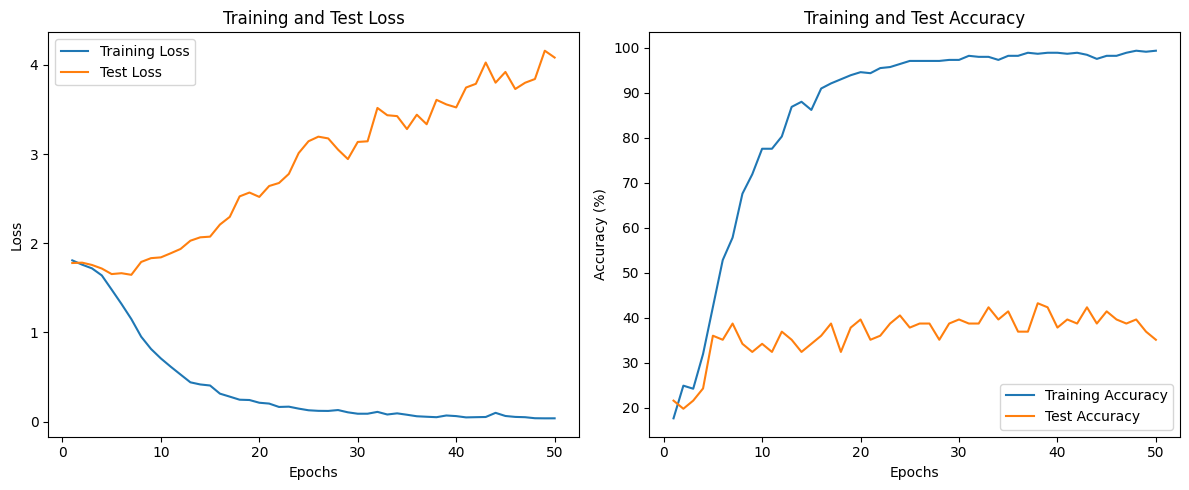

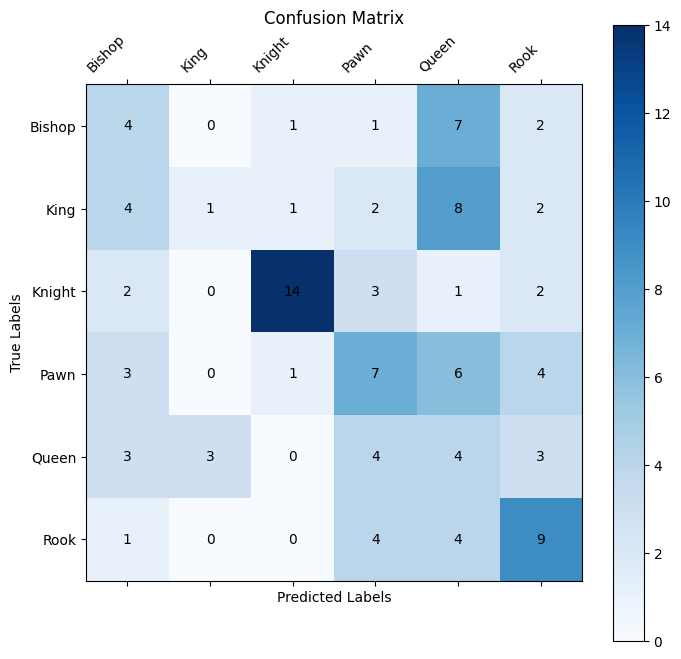

In [57]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

(Con parada temprana)

Epoch 1, Training Loss: 1.819518689598356, Training Accuracy: 16.3265306122449%
Epoch 1, Test Loss: 1.7833810704095023, Test Accuracy: 21.62162162162162%
Epoch 2, Training Loss: 1.734195304768426, Training Accuracy: 28.571428571428573%
Epoch 2, Test Loss: 1.7896014281681605, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.6594038009643555, Training Accuracy: 32.87981859410431%
Epoch 3, Test Loss: 1.7305147818156652, Test Accuracy: 32.432432432432435%
Epoch 4, Training Loss: 1.5083514835153307, Training Accuracy: 41.26984126984127%
Epoch 4, Test Loss: 1.7210499048233032, Test Accuracy: 33.333333333333336%
Epoch 5, Training Loss: 1.326270831482751, Training Accuracy: 53.74149659863946%
Epoch 5, Test Loss: 1.6405012266976493, Test Accuracy: 32.432432432432435%
Epoch 6, Training Loss: 1.1492011376789637, Training Accuracy: 56.235827664399096%
Epoch 6, Test Loss: 1.6624823638371058, Test Accuracy: 32.432432432432435%
Epoch 7, Training Loss: 0.9568969841514315, Training Accuracy:

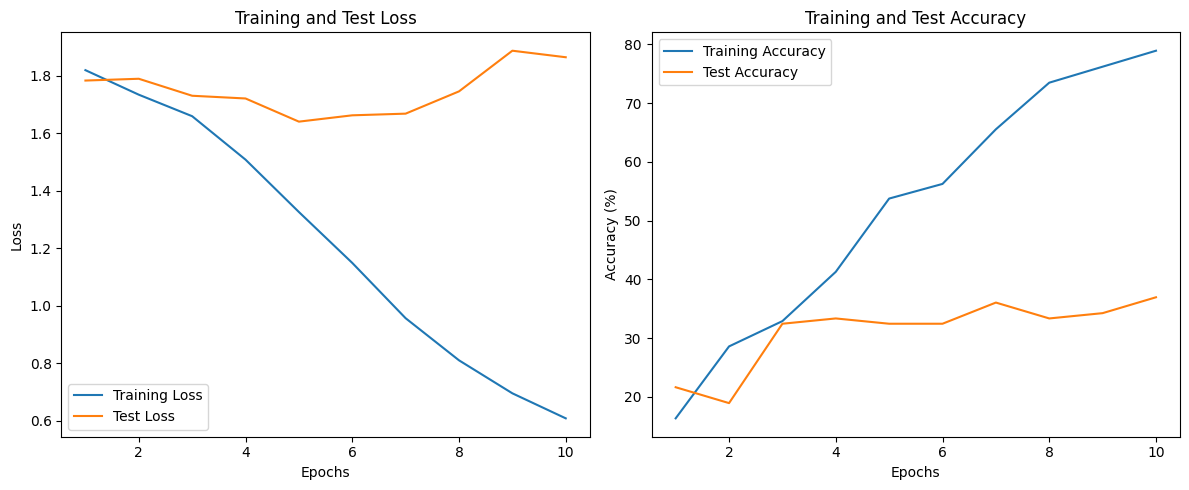

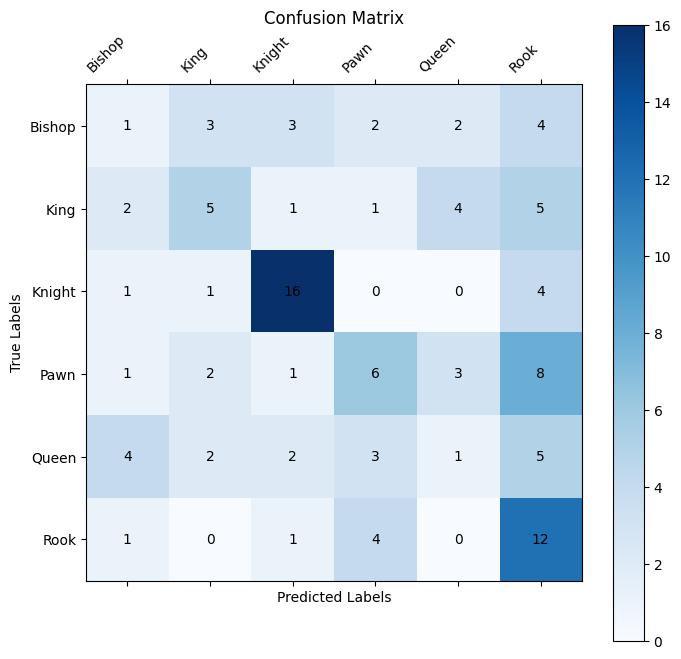

In [58]:
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)


Usando 4 capas convolutivas

Epoch 1, Training Loss: 1.7935768280710493, Training Accuracy: 18.594104308390023%
Epoch 1, Test Loss: 1.7886972257069178, Test Accuracy: 19.81981981981982%
Epoch 2, Training Loss: 1.7834628862994057, Training Accuracy: 19.27437641723356%
Epoch 2, Test Loss: 1.7874128137316023, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7664401573794228, Training Accuracy: 23.12925170068027%
Epoch 3, Test Loss: 1.768307430403573, Test Accuracy: 20.72072072072072%
Epoch 4, Training Loss: 1.7160676717758179, Training Accuracy: 24.94331065759637%
Epoch 4, Test Loss: 1.7395501136779785, Test Accuracy: 28.82882882882883%
Epoch 5, Training Loss: 1.631198491368975, Training Accuracy: 35.600907029478456%
Epoch 5, Test Loss: 1.6610205173492432, Test Accuracy: 31.53153153153153%
Epoch 6, Training Loss: 1.4860069581440516, Training Accuracy: 39.909297052154194%
Epoch 6, Test Loss: 1.72744916166578, Test Accuracy: 28.82882882882883%
Epoch 7, Training Loss: 1.3299333921500616, Training Accuracy: 47

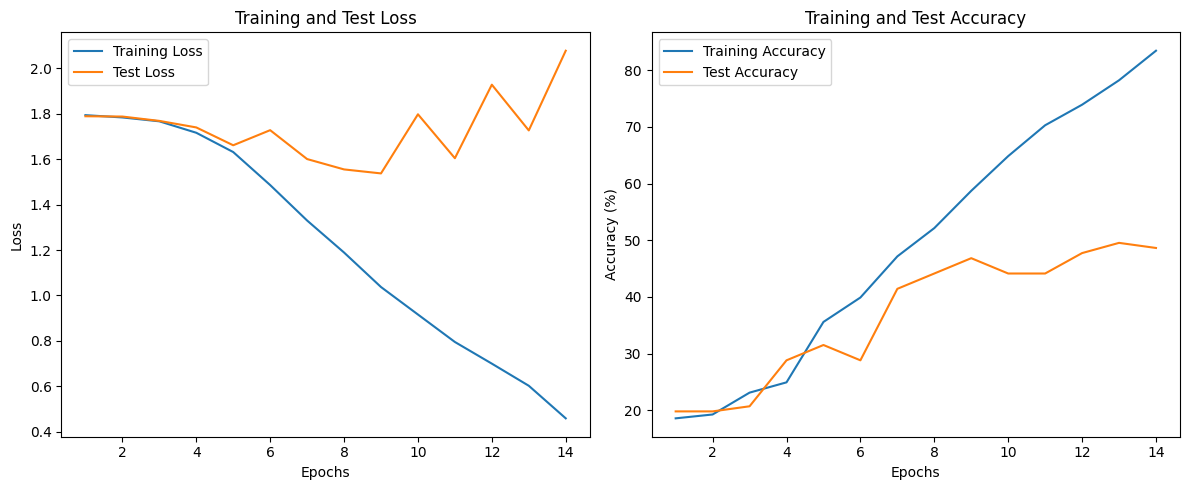

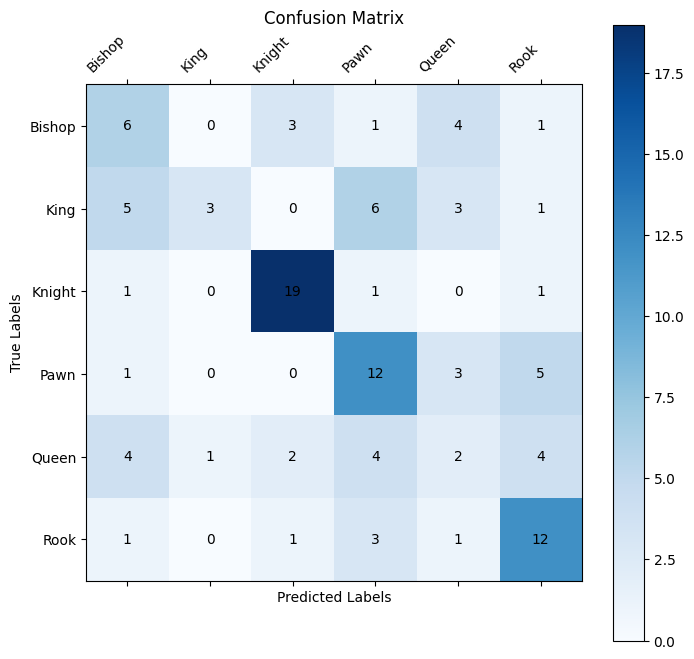

In [59]:
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

6 capas convolutivas y dropout

Epoch 1, Training Loss: 1.792313005243029, Training Accuracy: 18.820861678004537%
Epoch 1, Test Loss: 1.7882140704563685, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.7824337695326125, Training Accuracy: 16.099773242630384%
Epoch 2, Test Loss: 1.7889707769666399, Test Accuracy: 18.91891891891892%
Epoch 3, Training Loss: 1.7792086558682578, Training Accuracy: 15.873015873015873%
Epoch 3, Test Loss: 1.7805227041244507, Test Accuracy: 20.72072072072072%
Epoch 4, Training Loss: 1.7582892520087106, Training Accuracy: 21.08843537414966%
Epoch 4, Test Loss: 1.9717241355351038, Test Accuracy: 20.72072072072072%
Epoch 5, Training Loss: 1.781152035508837, Training Accuracy: 20.861678004535147%
Epoch 5, Test Loss: 1.7666230201721191, Test Accuracy: 23.423423423423422%
Epoch 6, Training Loss: 1.760349588734763, Training Accuracy: 19.954648526077097%
Epoch 6, Test Loss: 1.723196608679635, Test Accuracy: 19.81981981981982%
Epoch 7, Training Loss: 1.7271896771022253, Training Accuracy:

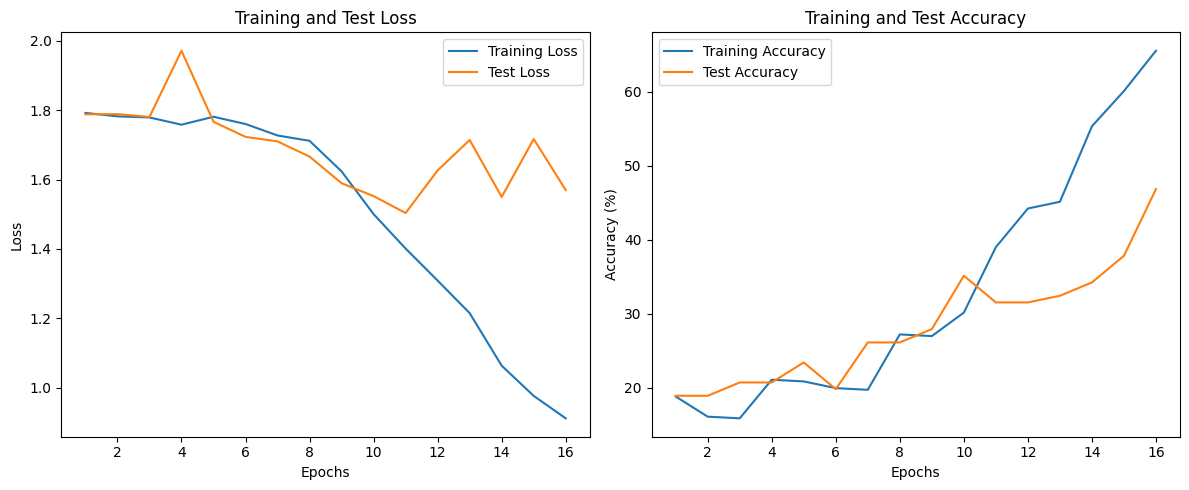

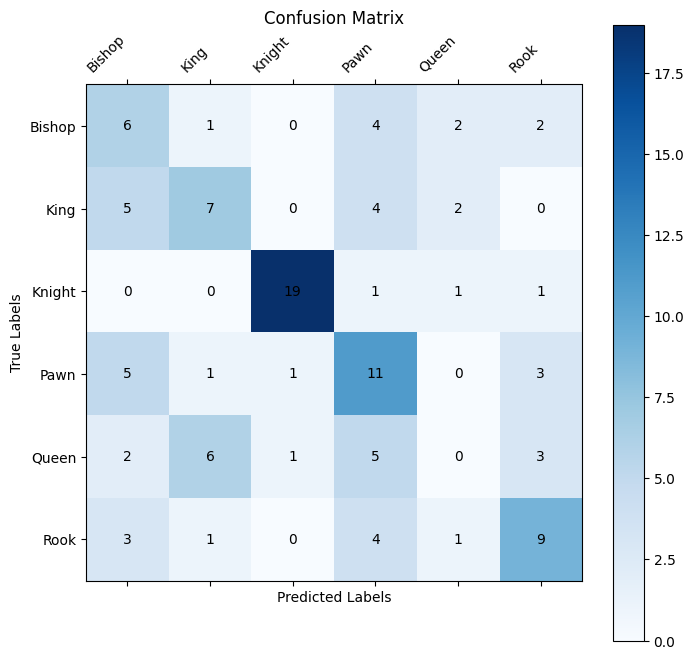

In [61]:
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)